<a href="https://colab.research.google.com/github/Fyodor-DOs/PCVK_02_Ahmed-Fathir-Syafaat/blob/main/Week7_Tugas_Kelompok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NAMA  : AHMED FATHIR SYAFAAT
#KELAS : TI - 3H




## TUGAS KELOMPOK WEEK 7

In [1]:
# Akses google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import math
from google.colab.patches import cv2_imshow
from PIL import Image as im

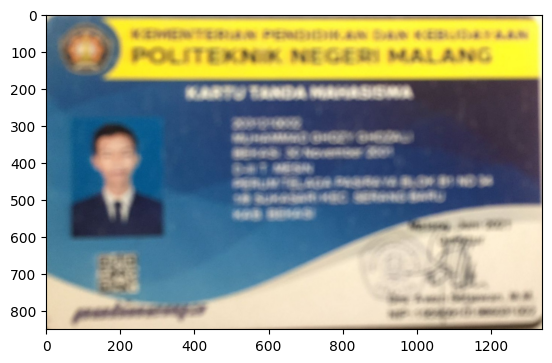

In [4]:
ktm = cv.imread('/content/drive/MyDrive/PCVK/Images/KTM.jpg')
ktm = cv.cvtColor(ktm, cv.COLOR_BGR2RGB)
plt.imshow(ktm)

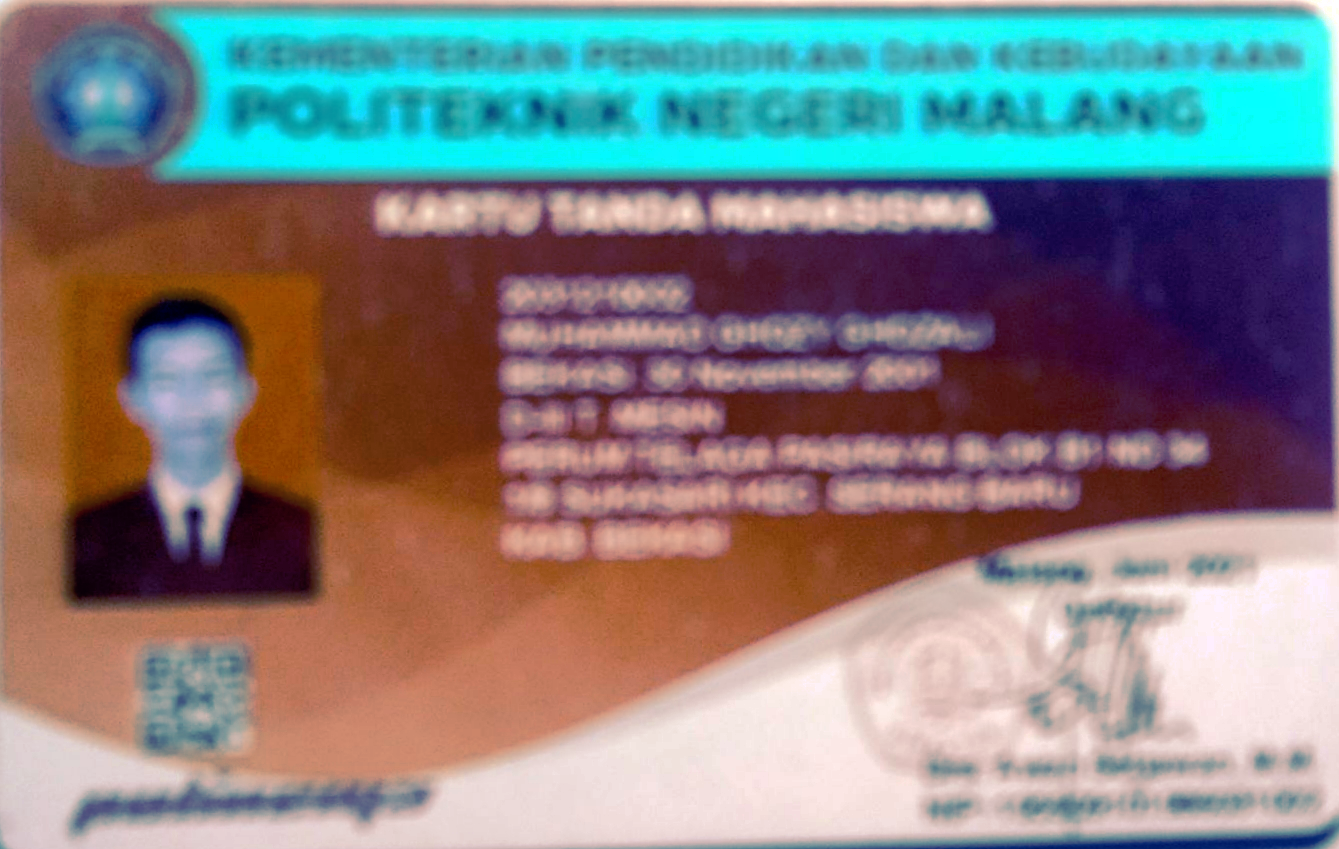

In [5]:
# Histogram equalization
channels = cv.split(ktm)
equalized_channels = []
for channel in channels:
    equalized_channel = cv.equalizeHist(channel)
    equalized_channels.append(equalized_channel)

ktm_equalized = cv.merge(equalized_channels)
cv2_imshow(ktm_equalized)

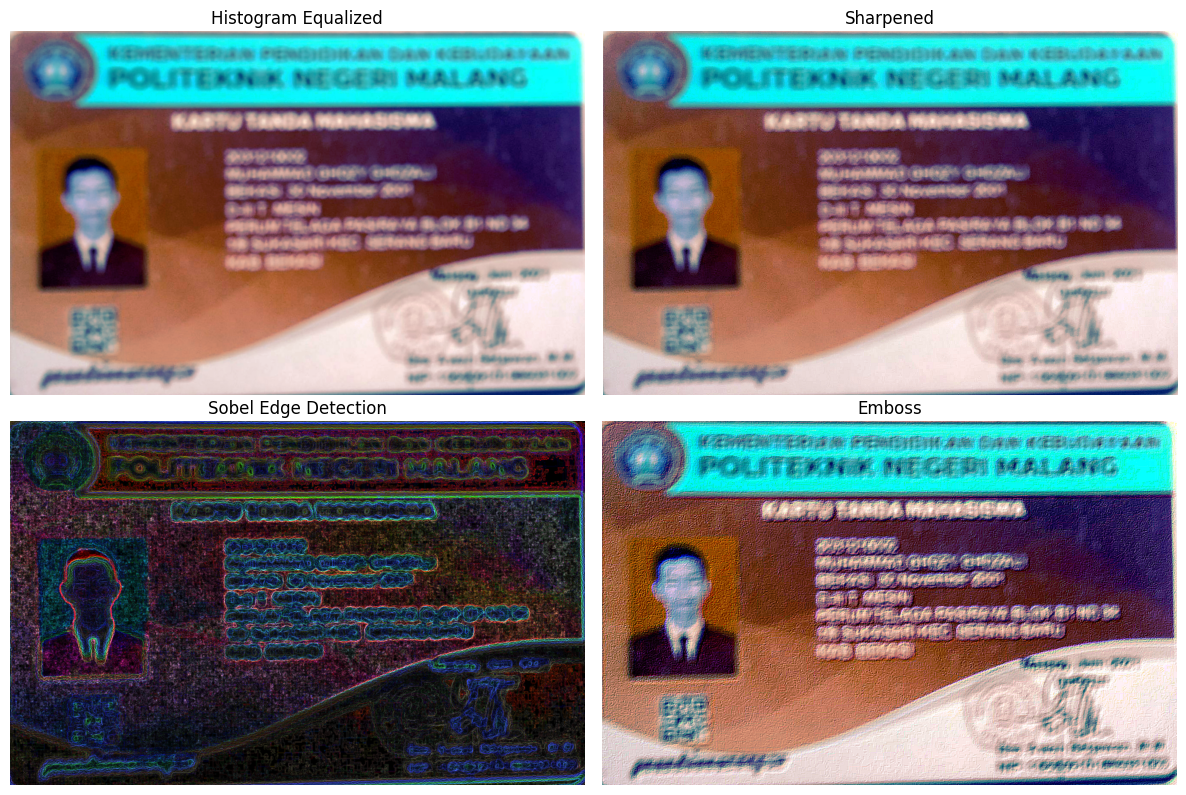

In [6]:
# Pisahkan citra menjadi saluran warna
channels = cv.split(ktm)

# Terapkan equalization histogram ke setiap saluran
equalized_channels = [cv.equalizeHist(channel) for channel in channels]

# Gabungkan saluran warna setelah histogram equalization
ktm_equalized = cv.merge(equalized_channels)

# Terapkan filter penajaman untuk meningkatkan detail
sharpen_kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])
ktm_sharpened = cv.filter2D(ktm_equalized, -1, sharpen_kernel)

# Terapkan deteksi tepi Sobel untuk mendeteksi tepi horizontal dan vertikal
sobel_x = cv.Sobel(ktm_sharpened, cv.CV_64F, 1, 0, ksize=3)
sobel_y = cv.Sobel(ktm_sharpened, cv.CV_64F, 0, 1, ksize=3)
sobel_edges = cv.magnitude(sobel_x, sobel_y)

# Ubah magnitude menjadi 8-bit untuk ditampilkan
sobel_edges_8u = cv.convertScaleAbs(sobel_edges)

# Emboss filter
emboss_kernel = np.array([[-2, -1, 0],
                          [-1,  1, 1],
                          [ 0,  1, 2]])
ktm_embossed = cv.filter2D(ktm_sharpened, -1, emboss_kernel)

# Tampilkan hasil
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Tampilkan hasil histogram equalized
ax[0, 0].imshow(cv.cvtColor(ktm_equalized, cv.COLOR_BGR2RGB))
ax[0, 0].set_title('Histogram Equalized')
ax[0, 0].axis('off')

# Tampilkan hasil sharpened
ax[0, 1].imshow(cv.cvtColor(ktm_sharpened, cv.COLOR_BGR2RGB))
ax[0, 1].set_title('Sharpened')
ax[0, 1].axis('off')

# Tampilkan hasil deteksi tepi Sobel
ax[1, 0].imshow(sobel_edges_8u, cmap='gray')
ax[1, 0].set_title('Sobel Edge Detection')
ax[1, 0].axis('off')

# Tampilkan hasil embossing
ax[1, 1].imshow(cv.cvtColor(ktm_embossed, cv.COLOR_BGR2RGB))
ax[1, 1].set_title('Emboss')
ax[1, 1].axis('off')

# Atur layout dan tampilkan
plt.tight_layout()
plt.show()

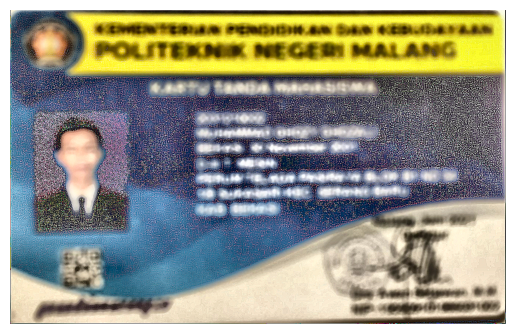

In [7]:
import cv2 as cv
import numpy as np
from scipy.signal import wiener
from matplotlib import pyplot as plt

def wiener_filter_rgb(image, kernel_size=(5,5)):
    # Split the image into R, G, B channels
    b, g, r = cv.split(image)

    # Apply Wiener filter to each channel
    r_filtered = wiener(r, kernel_size)
    g_filtered = wiener(g, kernel_size)
    b_filtered = wiener(b, kernel_size)

    # Merge the filtered channels back
    filtered_image = cv.merge((b_filtered.astype(np.uint8),
                               g_filtered.astype(np.uint8),
                               r_filtered.astype(np.uint8)))

    return filtered_image

# Example usage within an image enhancement workflow
def enhance_image_with_wiener_rgb(image_path):
    # Load the image
    image = cv.imread(image_path)

    # Apply the Wiener filter for noise reduction on RGB channels
    wiener_filtered_rgb = wiener_filter_rgb(image, kernel_size=(5, 5))

    # Convert image to LAB color space for contrast adjustments
    ktm_lab = cv.cvtColor(wiener_filtered_rgb, cv.COLOR_BGR2LAB)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) on the L-channel
    clahe = cv.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l, a, b = cv.split(ktm_lab)
    l_clahe = clahe.apply(l)

    #  Merge the CLAHE enhanced L-channel back with A and B channels
    ktm_lab_clahe = cv.merge((l_clahe, a, b))

    # Convert back to RGB color space
    ktm_clahe_rgb = cv.cvtColor(ktm_lab_clahe, cv.COLOR_LAB2BGR)

    # Apply sharpening to the image
    sharpen_kernel = np.array([[-1, -1, -1],
                               [-1,  9, -1],
                               [-1, -1, -1]])
    ktm_sharpened = cv.filter2D(ktm_clahe_rgb, -1, sharpen_kernel)

    #Display the final enhanced image with RGB color
    ktm_final = cv.cvtColor(ktm_sharpened, cv.COLOR_BGR2RGB)
    plt.imshow(ktm_final)
    plt.axis('off')
    plt.show()

# Call the function with your image path
enhance_image_with_wiener_rgb('/content/drive/MyDrive/PCVK/Images/KTM.jpg')


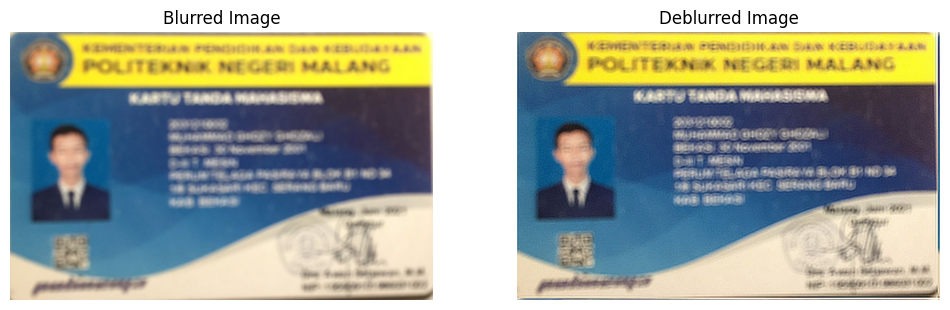

In [8]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2

# Define the Wiener filter function
def wiener_filter(img_blur, kernel, K):
    # Scale pixel values to 0-1
    img_blur = img_blur / 255
    deconv_img_blur = np.copy(img_blur)
    # Pad the kernel to match the image size
    kernel = np.pad(kernel, [(0, deconv_img_blur.shape[0] - kernel.shape[0]), (0, deconv_img_blur.shape[1] - kernel.shape[1])], mode='constant')

    # Apply Wiener filter to each channel separately
    for i in range(3):
        # Fourier Transform
        channel_blur = fft2(img_blur[:, :, i])
        kernel_fft = fft2(kernel)
        # Wiener filter
        kernel_fft = np.conj(kernel_fft) / (np.abs(kernel_fft) ** 2 + K)
        channel_deblurred = channel_blur * kernel_fft

        # Inverse Fourier Transform to spatial domain
        channel_deblurred = np.abs(ifft2(channel_deblurred))
        deconv_img_blur[:, :, i] = channel_deblurred

    # Scale pixel values back to 1-255
    deconv_img_blur = np.clip(deconv_img_blur * 255, 0, 255)
    return np.uint8(deconv_img_blur)

# Load the blurred image
ktm = cv.imread('/content/drive/MyDrive/PCVK/Images/KTM.jpg')
ktm = cv.cvtColor(ktm, cv.COLOR_BGR2RGB)

# Define a Gaussian kernel for deblurring
kernel_size = 15
sigma = 3
gaussian_kernel = cv.getGaussianKernel(kernel_size, sigma) * cv.getGaussianKernel(kernel_size, sigma).T

# Regularization constant
K = 0.01

# Apply the Wiener filter
deblurred_img = wiener_filter(ktm, gaussian_kernel, K)

# Display the original and deblurred images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(ktm)
plt.title("Blurred Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(deblurred_img)
plt.title("Deblurred Image")
plt.axis('off')

plt.show()
